In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tqdm
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim


In [ ]:
path = 'archive/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/'
comics_path = path + 'comics/'
face_path = path + 'face/'

comics = []
face = []
for i in os.listdir(comics_path):
    comics.append(comics_path + i)

for i in os.listdir(face_path):
    face.append(face_path + i)

print(comics[0])
print(face[0])

archive/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/comics/0.jpg
archive/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/face/0.jpg


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.set_device(0)
    print("Using GPU")

Using GPU


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Downsampling
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
        # Upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 3, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [60]:
face_train = face[:8000]
comics_train = comics[:8000]

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

class PairedImageDataset(Dataset):
    def __init__(self, face_paths, comic_paths, transform=None):
        self.face_paths = face_paths
        self.comic_paths = comic_paths
        self.transform = transform

    def __len__(self):
        return len(self.face_paths)

    def __getitem__(self, idx):
        face_image = Image.open(self.face_paths[idx]).convert("RGB")
        comic_image = Image.open(self.comic_paths[idx]).convert("RGB")
        
        if self.transform:
            face_image = self.transform(face_image)
            comic_image = self.transform(comic_image)
        
        return face_image, comic_image

paired_dataset = PairedImageDataset(face_paths=face_train, comic_paths=comics_train, transform=transform)
dataloader = DataLoader(paired_dataset, batch_size=16, shuffle=True)

model = UNet().to(device)
model.load_state_dict(torch.load('unet_model2.pth'))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [98]:
prev_losses = losses
prev_losses

[0.1123903399258852,
 0.0958906279206276,
 0.08500774549692869,
 0.07565628331899643,
 0.06763566566258669,
 0.06074939317256212,
 0.05453247098624706,
 0.049134692400693895,
 0.04436805395781994,
 0.04025992349907756,
 0.03661898858100176,
 0.03337883499637246,
 0.03070443945005536,
 0.028363557383418083,
 0.026276792734861373,
 0.024843249287456275,
 0.023139818988740443,
 0.02276332261785865,
 0.02175115104392171,
 0.02040750290080905]

In [ ]:
#Training 
num_epochs = 5
losses = []
for epoch in tqdm.tqdm(range(num_epochs)):
    epoch_loss = 0.0
    for original, comic in dataloader:
        optimizer.zero_grad()
        original = original.to(device)
        comic = comic.to(device)
        output = model(original)
        loss = criterion(output, comic)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    prev_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

 20%|██        | 1/5 [03:06<12:26, 186.53s/it]

Epoch [1/5], Loss: 0.0197


 40%|████      | 2/5 [06:03<09:02, 180.74s/it]

Epoch [2/5], Loss: 0.0193


 60%|██████    | 3/5 [08:56<05:54, 177.37s/it]

Epoch [3/5], Loss: 0.0183


 80%|████████  | 4/5 [11:50<02:55, 175.83s/it]

Epoch [4/5], Loss: 0.0179


100%|██████████| 5/5 [14:43<00:00, 176.70s/it]

Epoch [5/5], Loss: 0.0188


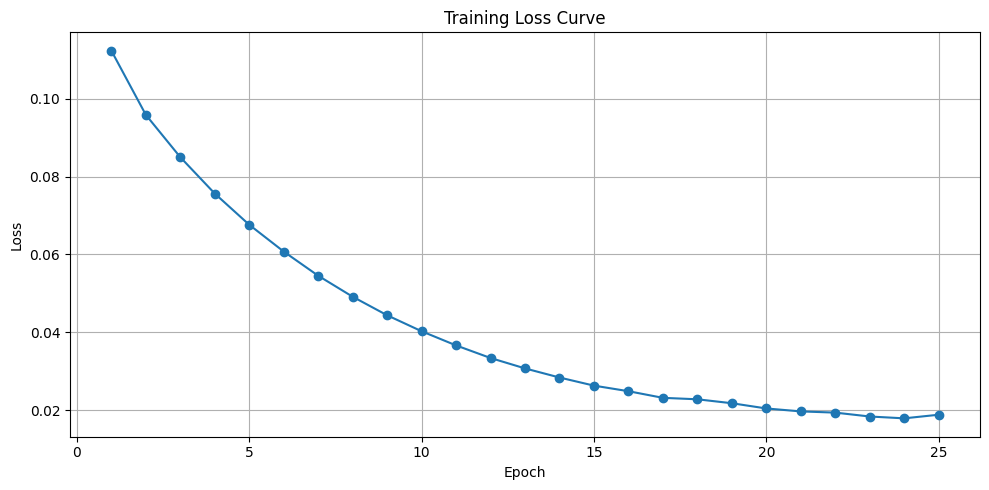

In [100]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 25+1), prev_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
face_test = face[8000:]
comics_test = comics[8000:]

In [102]:
test_dataset = PairedImageDataset(face_paths=face_test, comic_paths=comics_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [103]:
model.eval()
test_loss = 0.0

with torch.no_grad():
    for original, comic in test_loader:
        original = original.to(device)
        comic = comic.to(device)
        output = model(original)
        loss = criterion(output, comic)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 0.0194


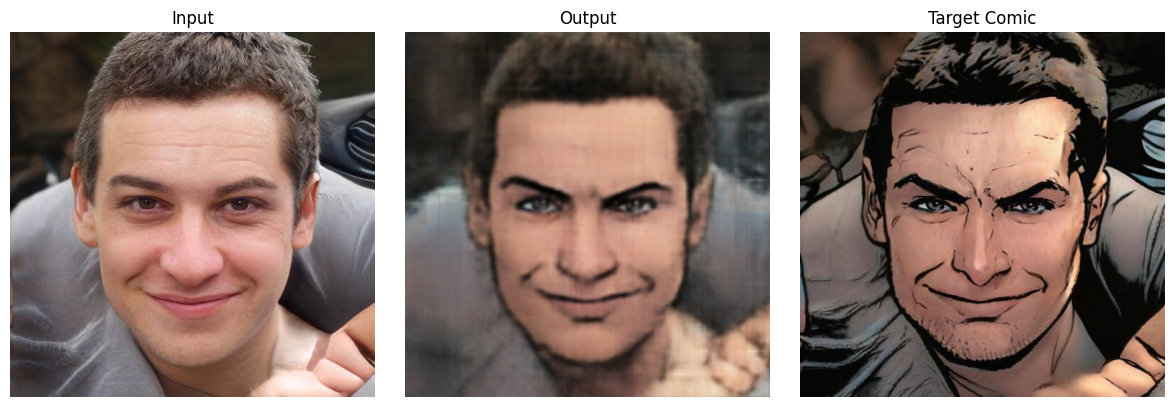

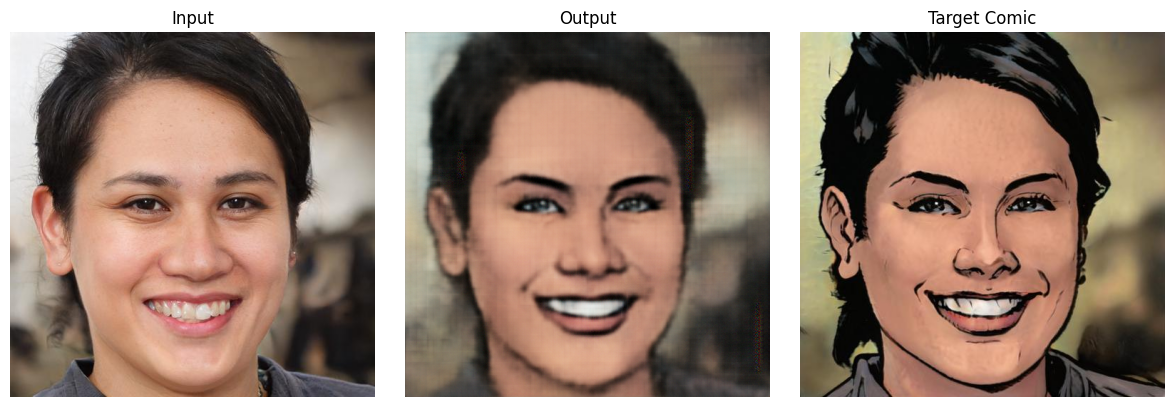

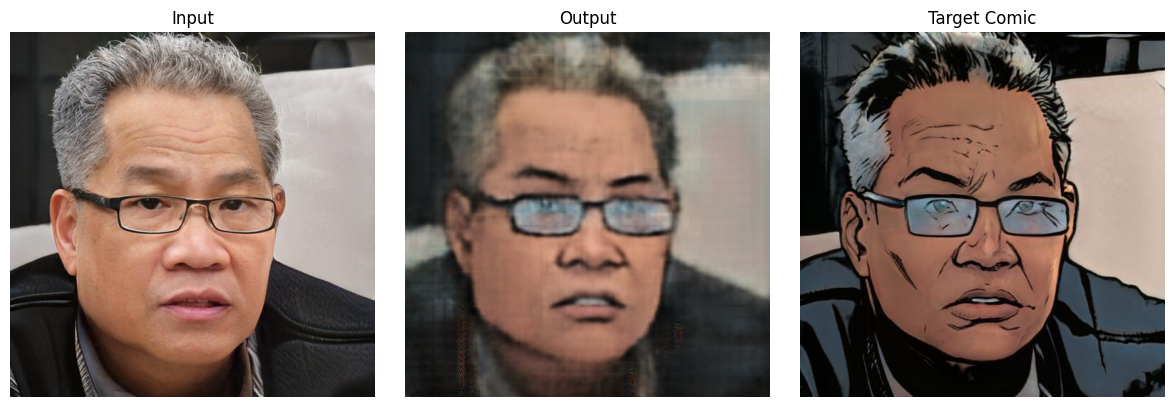

In [104]:
import matplotlib.pyplot as plt

original = original.cpu()
comic = comic.cpu()
output = output.cpu()

for i in range(3):  
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original[i].permute(1, 2, 0))
    axs[0].set_title("Input")
    axs[1].imshow(output[i].permute(1, 2, 0).clamp(0, 1)) 
    axs[1].set_title("Output")
    axs[2].imshow(comic[i].permute(1, 2, 0))
    axs[2].set_title("Target Comic")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [105]:
# save the model
torch.save(model.state_dict(), 'unet_model2.pth')

In [106]:
lab_test = Image.open('Lab_Test2.jpg').convert("RGB")

In [107]:
out = model(transform(lab_test).to(device).reshape(1, 3, 512, 512))
out = out.cpu().detach().numpy().reshape(3, 512, 512)
out = out.transpose(1, 2, 0)


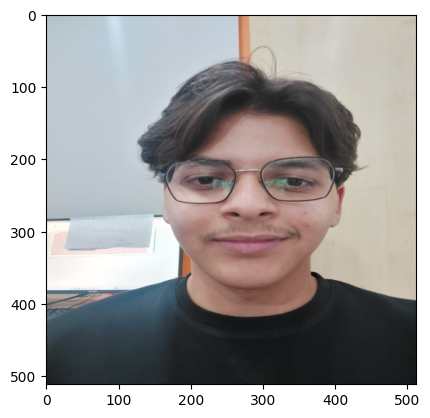

In [108]:
plt.imshow(transform(lab_test).cpu().detach().numpy().transpose(1, 2, 0))

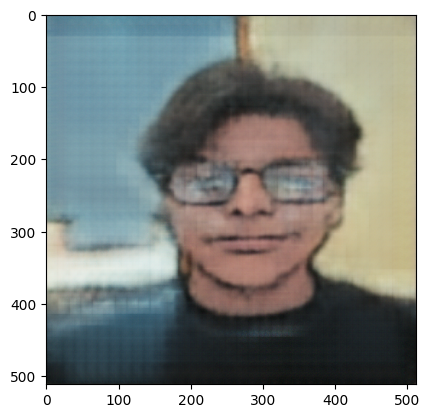

In [109]:
plt.imshow(out)

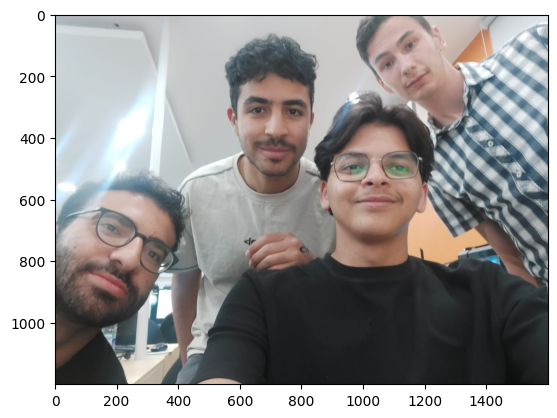

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99898833].


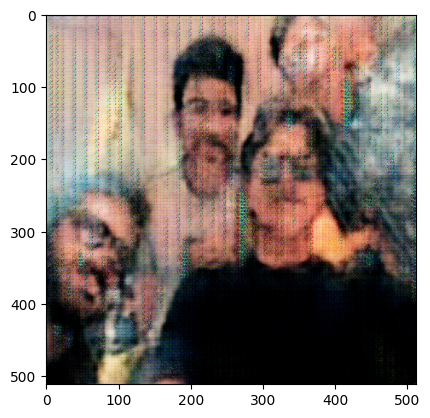

In [110]:
model = UNet().to(device)
model.load_state_dict(torch.load('unet_model2.pth'))
lab_test1 = Image.open('Lab_Test.jpg').convert("RGB")
out = model(transform(lab_test1).to(device).reshape(1, 3, 512, 512))
out = out.cpu().detach().numpy().reshape(3, 512, 512)
out = out.transpose(1, 2, 0)
plt.imshow(lab_test1)
plt.show()
plt.imshow(out)
plt.show()

In [111]:
prev_model = UNet().to(device)
prev_model.load_state_dict(torch.load('unet_model.pth'))

<All keys matched successfully>

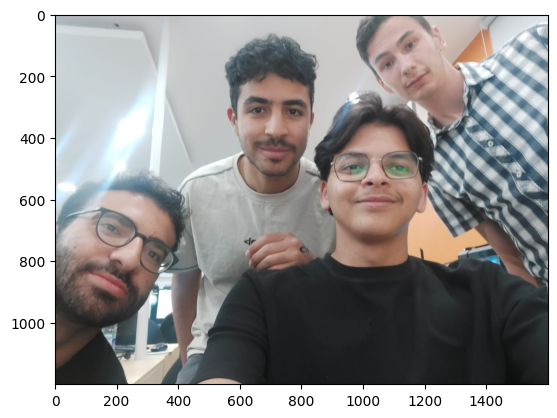

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.91301984].


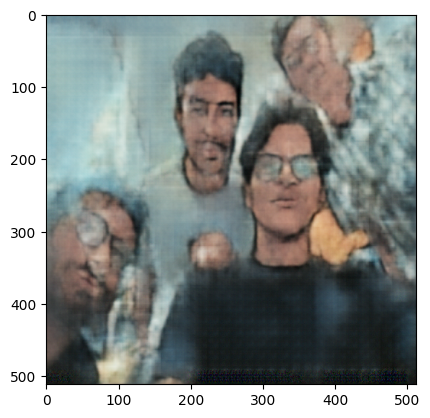

In [112]:
prev_model.eval()
lab_test1 = Image.open('Lab_Test.jpg').convert("RGB")
out2 = prev_model(transform(lab_test1).to(device).reshape(1, 3, 512, 512))
out2 = out2.cpu().detach().numpy().reshape(3, 512, 512)
out2 = out2.transpose(1, 2, 0)
plt.imshow(lab_test1)
plt.show()
plt.imshow(out2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99898833].


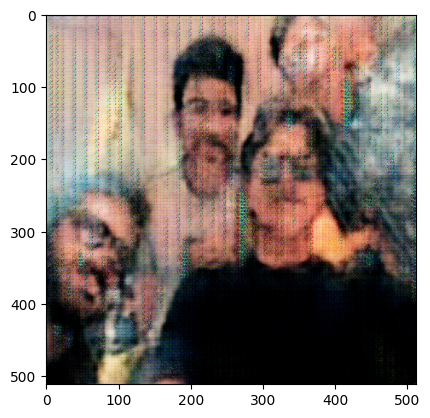

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.91301984].


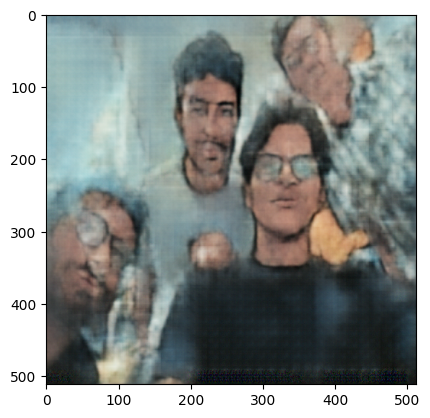

In [113]:
plt.imshow(out)
plt.show()
plt.imshow(out2)
plt.show()